# Install the OTT package, import the appropriate librairies, check you are using a GPU

In [1]:
import sys

if "google.colab" in sys.modules:

    !pip install -q git+https://github.com/ott-jax/ott@main

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install pot

Load the usual packages and those related to jax and ott and pot

In [3]:
import numpy as np
import os
from typing import Any, Callable, Sequence, Tuple
from typing import Iterator, Optional
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
import torchvision
import torch

import jax
import jax.numpy as jnp
import jax.random as random
from functools import partial
from jax import jit
import optax
from optax._src import base
import flax.linen as nn
from flax.training import train_state

import ott
from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from ott.tools.sinkhorn_divergence import sinkhorn_divergence

import ot


PRNGKey = Any
Shape = Tuple[int]
Dtype = Any
Array = Any

If you are using the colab GPU, the following cell should print "gpu". If not, you can run this notebook on a CPU but it will be a bit slower.

In [4]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu
cpu


In [5]:
# Plotting functions
def just_plot(sample, color = "violet", label="", figsize=(5, 5)):
    x_sample = np.array(sample[:,0])
    y_sample = np.array(sample[:,1])
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()
    ax.scatter(x_sample, y_sample,  s=10, color=color, label=label)
    plt.legend()
    plt.show()

def draw(source_sample, target_sample, state):
    ot_map_point = jax.grad(state.apply_fn, argnums=1)
    ot_map = jax.vmap(lambda x: ot_map_point({'params': state.params}, x))
    predicted = ot_map(source_sample)
    x_pred = np.array(predicted[:,0])
    y_pred = np.array(predicted[:,1])
    x_target = np.array(target_sample[:,0])
    y_target = np.array(target_sample[:,1])
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot()
    ax.scatter(x_target, y_target,  s=10, color='pink', label="target")
    ax.scatter(x_pred, y_pred, s=10, label="predicted")
    plt.legend()
    plt.show()

def plot_dataset(sample, offset = 0):
    fig = plt.figure(figsize=(15, 15))
    columns = 5
    rows = 5
    for i in range(1, columns*rows +1):
        img = sample[offset+i].reshape(16,16)
        fig.add_subplot(rows, columns, i)
        plt.imshow(img, vmin=0.0, vmax=1.0)
    plt.show()

def plot_differences(source, target, state, offset=0):
    ot_map_point = jax.grad(state.apply_fn, argnums=1)
    ot_map = jax.vmap(lambda x: ot_map_point({'params': state.params}, x))
    predicted = ot_map(source)
    fig = plt.figure(figsize=(15, 6))
    columns = 5
    rows = 2
    for i in range(1, columns*rows +1):
        if i < 6 :
          img = source[offset+i].reshape(16,16)
        else :
          img = predicted[offset+i-5].reshape(16,16)
        fig.add_subplot(rows, columns, i)
        plt.imshow(img, vmin=0.0, vmax=1.0)
    plt.show()

## Setting

We have access to samples from $\mu$ and $\nu$ that are unknown probability distributions and we would like to estimate the OT map $T^*$ from $\mu$ to $\nu$ using these samples. Let us denote $(X_1, ..., X_n)$ and $(Y_1, ..., Y_n)$ the samples from $\mu$ and $\nu$ respectively and $\hat{\mu}_n$, $\hat{\nu}_n$ the empirical distributions associated to these samples. **During this session, we will see two different ways to approximate $T^*$. The first way consists in using the Entropic map and the second way is a deep learning method.**

# The Entropic map

A first way to approximate $T^*$ is to use the Entropic map which was defined during the OT course. This map is built from the OT plan associated to the entropic regularized problem between $\hat{\mu}_n$ and $\hat{\nu}_n$. Let us denote $g$ and $f$ the dual potentials returned by Sinkhorn algorithm. The entropic map is then defined as follows :

$$T_{\epsilon, n}(x) = \frac{\frac{1}{n} \sum_{i=1}^n Y_i e^{\frac{1}{\epsilon} \left(g_i - \frac{1}{2} \|x - Y_i\|^2 \right)}}{\frac{1}{n} \sum_{k=1}^n e^{\frac{1}{\epsilon} \left(g_k - \frac{1}{2} \|x - Y_k\|^2 \right)}}$$

The entropic map $T_{\epsilon, n}$ allows to transport a new point $x \sim \mu$ on the $\nu$ distribution. Let us see how to implement it for specific distributions $\mu$ and $\nu$ and samples from them.

We generate i.i.d. samples from a source distribution P, which we always take to be [−1, 1]d
,
and from a target distribution Q = (T0)]P, where we define T0 : R
d → R
d
to be an optimal
transport map obtained by applying a monotone scalar function coordinate-wise.

**Real sample :**

In [12]:
def input_sampler(key, n_dim):
  """Sample a point uniformaly in a n_dim dimension
  """

  sample = jax.random.uniform(key, shape=(n_dim,), minval=-1.0, maxval=1.0)
  return sample


In [13]:
class Source_sampler:
    def __init__(self , dim: int=2):
        self.dim = dim
        self.setup()

    def setup(self):
        """
        Create a uniform sampler.
        """

        @partial(jit, static_argnums=1)
        def generate_samples(key, num_samples):
            """This function takes a random key and a number of samples and returns a array of points.
            """
            list_key = jax.random.split(key, num=num_samples)
            points = points = jax.vmap(lambda key: input_sampler(key, self.dim))(list_key)


            return points

        self.generate_samples = generate_samples

In [53]:
def output_sampler(key):
    """Sample a point from the output distribution."""
    key_x = jax.random.split(key)[0]
    x = jax.random.uniform(key_x) * 2 - 1
    y = 3 * x**2 * jnp.sign(x)  # Calculate y based on the given distribution
    return jnp.array([x, y])


In [54]:
class Output_sampler:
    def __init__(self ):
        self.setup()

    def setup(self):
        """
        Create an output sampler.
        """

        @partial(jit, static_argnums=1)
        def generate_samples(key, num_samples):
            """This function takes a random key and a number of samples and returns a array of points.
            """

 #           """ Solution

            list_keys = jax.random.split(key, num=num_samples)
            points = jax.vmap(output_sampler)(list_keys)

#            """

            return points

        self.generate_samples = generate_samples

In [55]:
d = 2  # Dimensionality
num_samples = 1000  # Number of samples

# Generate i.i.d. samples from uniform distribution over [-1, 1]^d
input_sample = np.random.uniform(low=-1, high=1, size=(num_samples, d)) # source sample


def T_0(x):
    return 3 * x**2 * np.sign(x)

target_sample = T_0(input_sample) # target sample


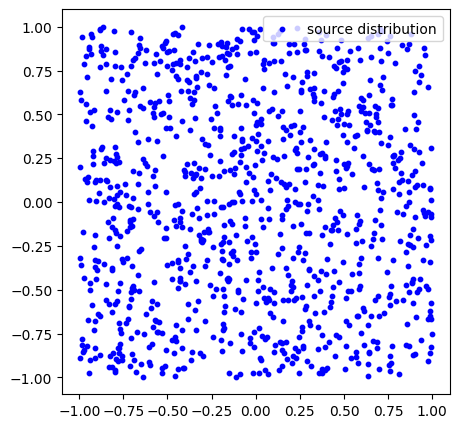

In [56]:
n=1024
rng = jax.random.PRNGKey(0)
# initiate sampler
source_sampler = Source_sampler()
# draw 1024 iid samples from it  (try removing the @partial(jit...))
X = source_sampler.generate_samples(rng, n)
# plot the samples obtained
just_plot(X, label="source distribution", color="blue")

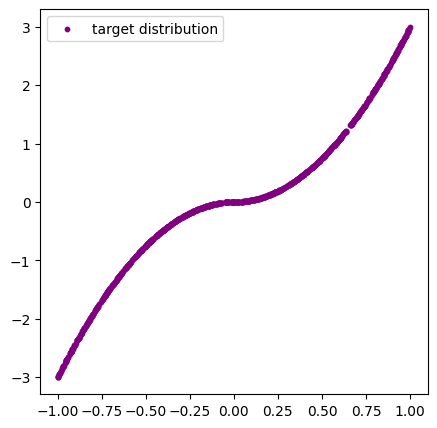

In [57]:
# initiate sampler
target_sampler = Output_sampler()
# draw 1024 iid samples from it
Y = target_sampler.generate_samples(rng, n)
# plot the samples obtained
just_plot(Y, label="target distribution", color="purple")

C'EST PAS CA

**Estimated sample :**

In [58]:
epsilon=0.1
n = len(X)

geom = ott.geometry.pointcloud.PointCloud(X, Y)                   # Define an euclidean geometry
problem = ott.problems.linear.linear_problem.LinearProblem(geom)  # Define your problem
solver = ott.solvers.linear.sinkhorn.Sinkhorn()                   # Select the Sinkhorn solver

out = solver(problem)                                             # Solve it !

f = out.f                                                         # Get back the potentials f and g
g = out.g

In [59]:
def entropic_map_(x, g=g, Y=Y, epsilon=epsilon, n=n):
    """
    Compute the entropic map
    """
#    """ Solution

    exp = jnp.exp( 1 / epsilon * (g - 1/2 * jnp.sum((x - Y)**2, axis=1)) )
    exp = jnp.expand_dims(exp, axis=1)
    return jnp.sum(Y * exp, axis = 0) / jnp.sum(exp)

#    """

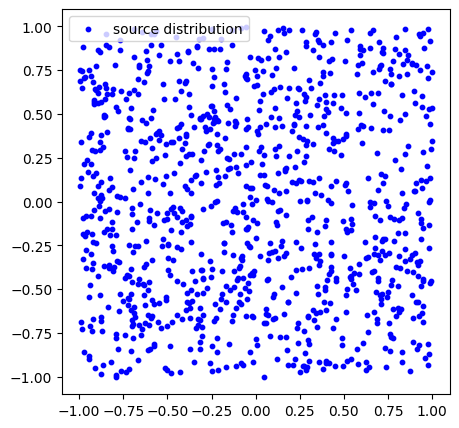

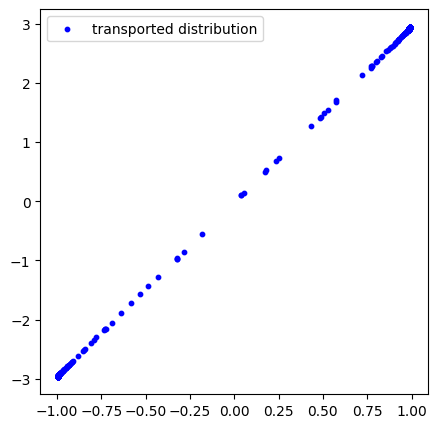

In [60]:
# Use jax.vmap to define a function that takes a batch of samples as input.
entropic_map_batch = jax.vmap(entropic_map_, in_axes=0, out_axes=0)

# Draw new samples X' from the source distribution
rng, rng_2 = jax.random.split(rng, num=2)
X_p = source_sampler.generate_samples(rng_2, n)

# Transport the batch X' with that function
transported_samples = entropic_map_batch(X_p)

# Plot the init_samples and transported samples
just_plot(X_p, label="source distribution", color="blue")
just_plot(transported_samples, label="transported distribution", color="blue")

**Last Code from TP:**

In [6]:
def unit_ball_sampler(key, n_dim):
  """Sample a point uniformaly in a n_dim dimension unit ball

  Hint: Use the following quote:

      If Y is drawn from the uncorrelated multivariate normal distribution,
      then S = Y / ||Y|| has the uniform distribution on the unit d-sphere.
      Multiplying S by U^1/d, where U has the uniform distribution on the unit
      interval (0,1), creates the uniform distribution in the unit d-dimensional ball.
  """

#  """Solution

  key_y, key_u = jax.random.split(key)
  y = jax.random.normal(key_y, shape=(n_dim,))
  u = jax.random.uniform(key_u)

  return y / jnp.linalg.norm(y) * u**(1/n_dim)

#  """


In [19]:
def banana_sampler(key):
  """Sample a point from a banana shape distribution

  """

  key_x, key_phi, key_z = jax.random.split(key, num=3)
  x = jax.random.uniform(key_x) * 2 - 1
  phi = jax.random.uniform(key_phi) * 2 * jnp.pi
  z = jax.random.uniform(key_z)
  r = 0.2 * z * (1 + (1 - jnp.abs(x)) / 2)

  return jnp.array([ x + r * jnp.cos(phi), x**2 + r * jnp.sin(phi)])

In [8]:
class Unit_ball_sampler:
    def __init__(self , dim: int=2):
        self.dim = dim
        self.setup()

    def setup(self):
        """
        Create a unit ball sampler.
        """

        @partial(jit, static_argnums=1)
        def generate_samples(key, num_samples):
            """This function takes a random key and a number of samples and returns a array of points.

                Hint: Use the unit ball sampler and vmap
            """

#            """ Solution

            list_key = jax.random.split(key, num=num_samples)
            points = jax.vmap(lambda key: unit_ball_sampler(key, self.dim))(list_key)

#            """

            return points

        self.generate_samples = generate_samples

In [9]:
class Banana_shaped_sampler:
    def __init__(self ):
        self.setup()

    def setup(self):
        """
        Create a banana shaped sampler.
        """

        @partial(jit, static_argnums=1)
        def generate_samples(key, num_samples):
            """This function takes a random key and a number of samples and returns a array of points.

                Hint: Use the banana sampler and vmap
            """

 #           """ Solution

            list_keys = jax.random.split(key, num=num_samples)
            points = jax.vmap(banana_sampler)(list_keys)

#            """

            return points

        self.generate_samples = generate_samples

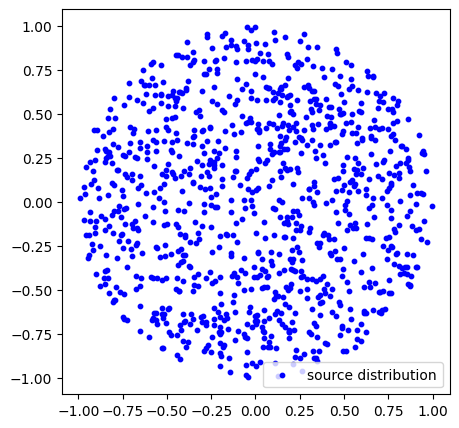

In [10]:
n=1024
rng = jax.random.PRNGKey(0)
# initiate sampler
source_sampler = Unit_ball_sampler()
# draw 1024 iid samples from it  (try removing the @partial(jit...))
X = source_sampler.generate_samples(rng, n)
# plot the samples obtained
just_plot(X, label="source distribution", color="blue")

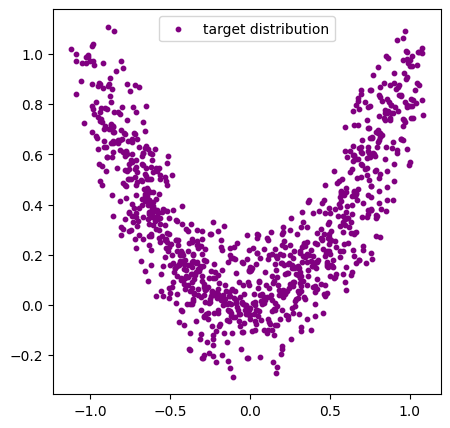

In [11]:
# initiate sampler
target_sampler = Banana_shaped_sampler()
# draw 1024 iid samples from it
Y = target_sampler.generate_samples(rng, n)
# plot the samples obtained
just_plot(Y, label="target distribution", color="purple")

In [113]:
epsilon=0.1
n = len(X)

geom = ott.geometry.pointcloud.PointCloud(X, Y)                   # Define an euclidean geometry
problem = ott.problems.linear.linear_problem.LinearProblem(geom)  # Define your problem
solver = ott.solvers.linear.sinkhorn.Sinkhorn()                   # Select the Sinkhorn solver

out = solver(problem)                                             # Solve it !

f = out.f                                                         # Get back the potentials f and g
g = out.g

Once the potentials $f$ and $g$ have been computed, you can define the entropic map as defined above.
***
**Question:**
* Complete this function that takes as input $x$ which is a point in $\R^2$ (and not a batch of points) and return $T_{\epsilon, n}(x) \in \R^2$

In [114]:
def entropic_map_(x, g=g, Y=Y, epsilon=epsilon, n=n):
    """
    Compute the entropic map
    """
#    """ Solution

    exp = jnp.exp( 1 / epsilon * (g - 1/2 * jnp.sum((x - Y)**2, axis=1)) )
    exp = jnp.expand_dims(exp, axis=1)
    return jnp.sum(Y * exp, axis = 0) / jnp.sum(exp)

#    """

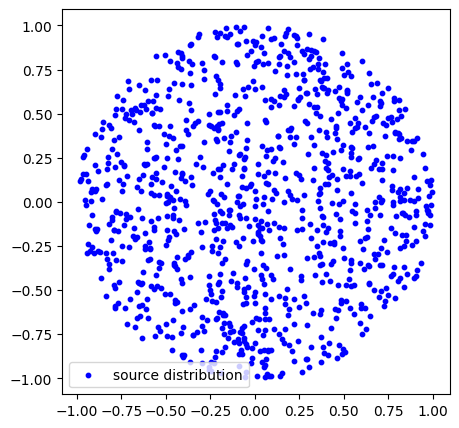

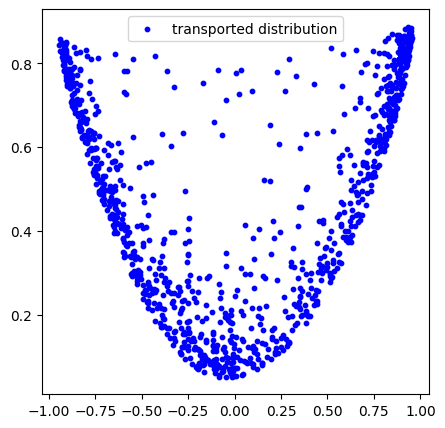

In [116]:
# Use jax.vmap to define a function that takes a batch of samples as input.
entropic_map_batch = jax.vmap(entropic_map_, in_axes=0, out_axes=0)

# Draw new samples X' from the source distribution
rng, rng_2 = jax.random.split(rng, num=2)
X_p = source_sampler.generate_samples(rng_2, n)

# Transport the batch X' with that function
transported_samples = entropic_map_batch(X_p)

# Plot the init_samples and transported samples
just_plot(X_p, label="source distribution", color="blue")
just_plot(transported_samples, label="transported distribution", color="blue")

We have transported a new set of samples X' using the entropic map. One can observe that the transported samples look like the one drawn from the target distribution but that it is not perfect. This is because our implementation of the entropic map is not optimal. Let us use the ott implementation of the sinkhorn map and transport X' again.


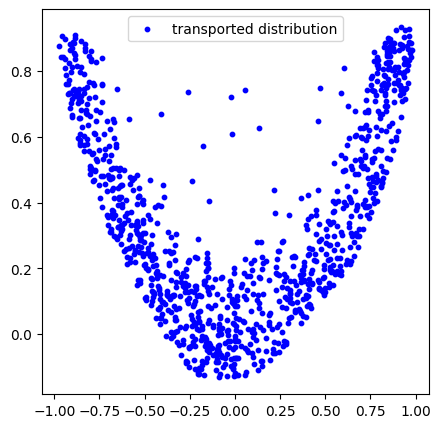

In [ ]:
# Define entropic map with the output of the solver
entropic_map = out.to_dual_potentials()

# Transport X with this map
transported_samples = entropic_map.transport(X_p)

# Plot the transported samples
just_plot(transported_samples, label="transported distribution", color="blue")

This time, the transported samples really look like those drawn from the banana distribution.

The entropic map is a first method to approximate the OT map $T^*$, we will now see another way to approximate $T^*$ using neural networks.